# Importaciones

In [2]:
from pycocotools.coco import COCO
import os
import shutil
import json
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from collections import defaultdict

from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models
from torch import optim
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet50_Weights

# Cargamos la arquitectura

In [4]:
#model = models.resnet18(weights=None)
model = models.resnet50(weights=None)

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
class MLC(nn.Module):
    def __init__(self, num_classes):
        super(MLC, self).__init__()
        self.resnet = models.resnet50(weights=None)
        self.in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.in_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x


In [12]:
# Definir los dispositivos (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo actual:", device)
# Cargar el archivo de anotaciones final
annotations_path = r"F:\Train_IA\train2017\annotations\instances_train2017.json"
coco = COCO(annotations_path)

# Obtener las categorías y asignarlas a un índice
categories = coco.loadCats(coco.getCatIds())
category_names = {cat['id']: cat['name'] for cat in categories}

# Cargar las imágenes y sus anotaciones
image_ids = coco.getImgIds()
images_info = coco.loadImgs(image_ids)

# Definir las transformaciones para el preprocesamiento de las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir la imagen a un tensor
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar
])

# Función para cargar las anotaciones
def load_annotations(img_id):
    ann_ids = coco.getAnnIds(imgIds=[img_id])
    annotations = coco.loadAnns(ann_ids)
    labels = [ann['category_id'] for ann in annotations]
    
    # Filtrar las etiquetas para que estén dentro del rango de las categorías disponibles
    valid_labels = [label - 1 for label in labels if 1 <= label <= len(categories)]
    
    return valid_labels

# Crear un Dataset para PyTorch
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, coco, images_info, categories, transform=None):
        self.coco = coco
        self.images_info = images_info
        self.categories = categories
        self.transform = transform
        
    def __len__(self):
        return len(self.images_info)
    
    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        img_id = img_info['id']
        img_path = os.path.join(r"C:\Users\USER\Downloads\train2017\train2017", img_info['file_name'])
        
        image = datasets.folder.default_loader(img_path)  # Cargar la imagen
        if self.transform:
            image = self.transform(image)  # Aplicar las transformaciones
        
        labels = load_annotations(img_id)  # Obtener las etiquetas para la imagen
        labels_tensor = torch.zeros(len(self.categories))  # Crear un tensor para las etiquetas
        
        # Marcar las posiciones correspondientes en el tensor de etiquetas
        for label in labels:
            labels_tensor[label] = 1  # Marcar la categoría correspondiente
        
        return image, labels_tensor

# Crear el DataLoader
dataset = CocoDataset(coco, images_info, categories, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Dispositivo actual: cuda
loading annotations into memory...
Done (t=25.23s)
creating index...
index created!


In [13]:
print(len(categories))
model = MLC(num_classes=len(categories))
model.resnet

if torch.cuda.is_available():
    model = model.to(device)
    print(device)


80
cuda


In [14]:
# Cargar el modelo en CPU
state_dict = torch.load(r".\modelo_pesos_todas_imagenes.pth", map_location=torch.device('cpu'))
new_state_dict = {k.replace('resnet.', ''): v for k, v in state_dict.items()}
model.resnet.load_state_dict(new_state_dict, strict=False)
model.eval()  # Poner el modelo en modo de evaluación

C:\Users\Juanja Malo\AppData\Local\Temp\ipykernel_25908\115343980.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(r".\modelo_pesos_todas_imagenes

MLC(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [15]:
# Crear un mapeo de índice a ID de categoría
id_to_index = {cat['id']: i for i, cat in enumerate(categories)}  # De COCO ID a índice
index_to_id = {v: k for k, v in id_to_index.items()}  # De índice a COCO ID
category_names = {cat['id']: cat['name'] for cat in categories}  # De COCO ID a nombre

print(category_names)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show(image_path, model, coco):
    model.eval()  # Poner el modelo en modo evaluación
    image = datasets.folder.default_loader(image_path)  # Cargar la imagen
    image_transformed = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones
    
    with torch.no_grad():
        outputs = model(image_transformed)  # Inferencia
        
    # Aplicar sigmoid para obtener probabilidades
    probs = torch.sigmoid(outputs).cpu().numpy()
    
    # Obtener los índices predichos (según el mapeo del modelo)
    predicted_indices = [i for i, p in enumerate(probs[0]) if p > 0.5]
    
    # Convertir índices a IDs de categoría (usando el mapeo index_to_id)
    predicted_ids = [index_to_id[i] for i in predicted_indices]
    
    # Obtener los nombres de las categorías
    labels = [category_names[cat_id] for cat_id in predicted_ids]
    
    # Mostrar la imagen con las etiquetas predichas
    plt.figure(figsize=(8, 8))
    plt.imshow(image)  # Mostrar la imagen
    plt.axis('off')  # Quitar ejes
    plt.title(f"Predicciones: {', '.join(labels)}", fontsize=12)  # Agregar las etiquetas como título
    plt.show()
    
    return labels

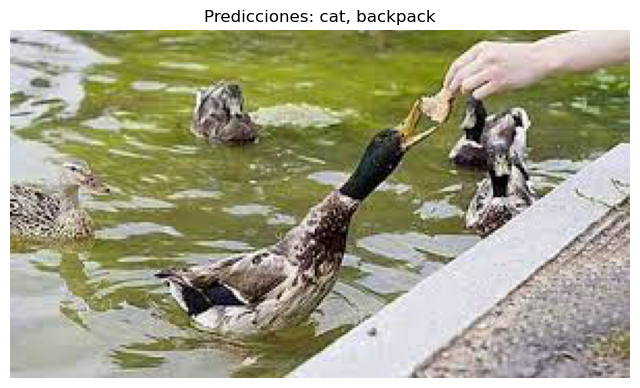

Etiquetas predichas:
['cat', 'backpack']


In [23]:
image_path = r"C:\Users\Juanja Malo\Desktop\e.jpg"  # Cambia a la ruta de tu imagen
predicted_labels = predict_and_show(image_path, model, coco)
print("Etiquetas predichas:")
print(predicted_labels)

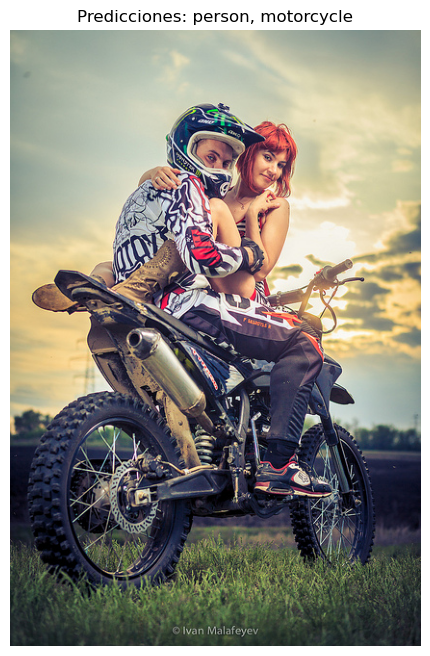

Etiquetas predichas:
['person', 'motorcycle']


In [24]:
image_path = r"F:\Train_IA\train2017\train2017\000000000529.jpg" # Cambia a la ruta de tu imagen
predicted_labels = predict_and_show(image_path, model, coco)
print("Etiquetas predichas:")
print(predicted_labels)